In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import os
from tqdm import tqdm
from sklearn import metrics

sc.set_figure_params(figsize=(6, 4))

In [11]:
def get_adata(path, meta):
    sample = path.split('/')[2].split('_')[2]
    adata = sc.read_10x_mtx(path, cache=True)
    adata.var_names_make_unique()
    sc.pp.filter_genes(adata, min_cells=10)
    
    adata.obs.index = [sample + '_' + name for name in adata.obs.index]
    msk = [name in meta.index for name in adata.obs.index]
    adata = adata[msk]
    adata.obs = pd.merge(adata.obs, meta, left_index=True,right_index=True)
    adata.obs['donor'] = sample
    
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    return adata

root_path = 'data/'
rna_path = root_path + 'rna_seq/'
lst_dirs = [dname for dname in os.listdir(rna_path) if os.path.isdir(rna_path+dname) and dname.startswith('2')]

meta = pd.read_csv('data/rna_seq/metadata.csv', index_col=0)

adatas = []
for i,d in enumerate(tqdm(lst_dirs)):
    path = rna_path + d + '/premrna_outs/filtered_feature_bc_matrix'
    tmp = get_adata(path, meta)
    adatas.append(tmp)
    del tmp
adata = adatas[0].concatenate(adatas[1:])

cc_genes = pd.read_table('data/Macosko_cell_cycle_genes.txt', delimiter='\t')
s_genes = list(cc_genes['S'].dropna())
g2m_genes = list(cc_genes['G2.M'].dropna())
s_genes = adata.var_names[np.in1d(adata.var_names, s_genes)]
g2m_genes = adata.var_names[np.in1d(adata.var_names, g2m_genes)]
sc_genes = np.hstack((s_genes,g2m_genes))
se_genes = np.array([gene.rstrip() for gene in open('data/seurat_ccgenes.csv', 'r').readlines()])
cc_genes = np.unique(np.hstack((sc_genes, se_genes)))

msk = np.array([gene in cc_genes for gene in adata.var.index])
h_adata = adata[:,~msk]
del adata

h_adata.var['mt'] = h_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(h_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pp.normalize_total(h_adata, target_sum=1e4)
sc.pp.log1p(h_adata)

sc.pp.highly_variable_genes(
    h_adata,
    flavor="seurat_v3",
    n_top_genes=512,
    layer="counts",
    batch_key="batch",
    subset=True
)

h_adata.raw = h_adata

adata = h_adata[:, h_adata.var.highly_variable]
adata = adata.copy()

100%|██████████| 5/5 [00:02<00:00,  2.22it/s]
Trying to set attribute `.var` of view, copying.


In [12]:
scvi.data.setup_anndata(adata, layer="counts", batch_key="batch", labels_key='cycling')

INFO      Using batches from adata.obs["batch"]                                              
INFO      Using labels from adata.obs["cycling"]                                             
INFO      Using data from adata.layers["counts"]                                             
INFO      Computing library size prior per batch                                             
INFO      Successfully registered anndata object containing 2222 cells, 512 genes, 5 batches,
          2 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
          extra continuous covariates.                                                       
INFO      Please do not further modify adata until model is trained.                         


/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/badi/anaconda3/env

In [13]:
model = scvi.model.SCVI(adata)

In [15]:
model.train()

INFO      Training for 400 epochs                                                            
INFO      KL warmup for 400 epochs                                                           


Output()

INFO      Training time:  184 s. / 400 epochs                                                


In [19]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [80]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(n_samples=1000)

In [24]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'broad_celltype' as categorical
... storing 'cycling' as categorical
... storing 'donor' as categorical
... storing 'feature_types' as categorical


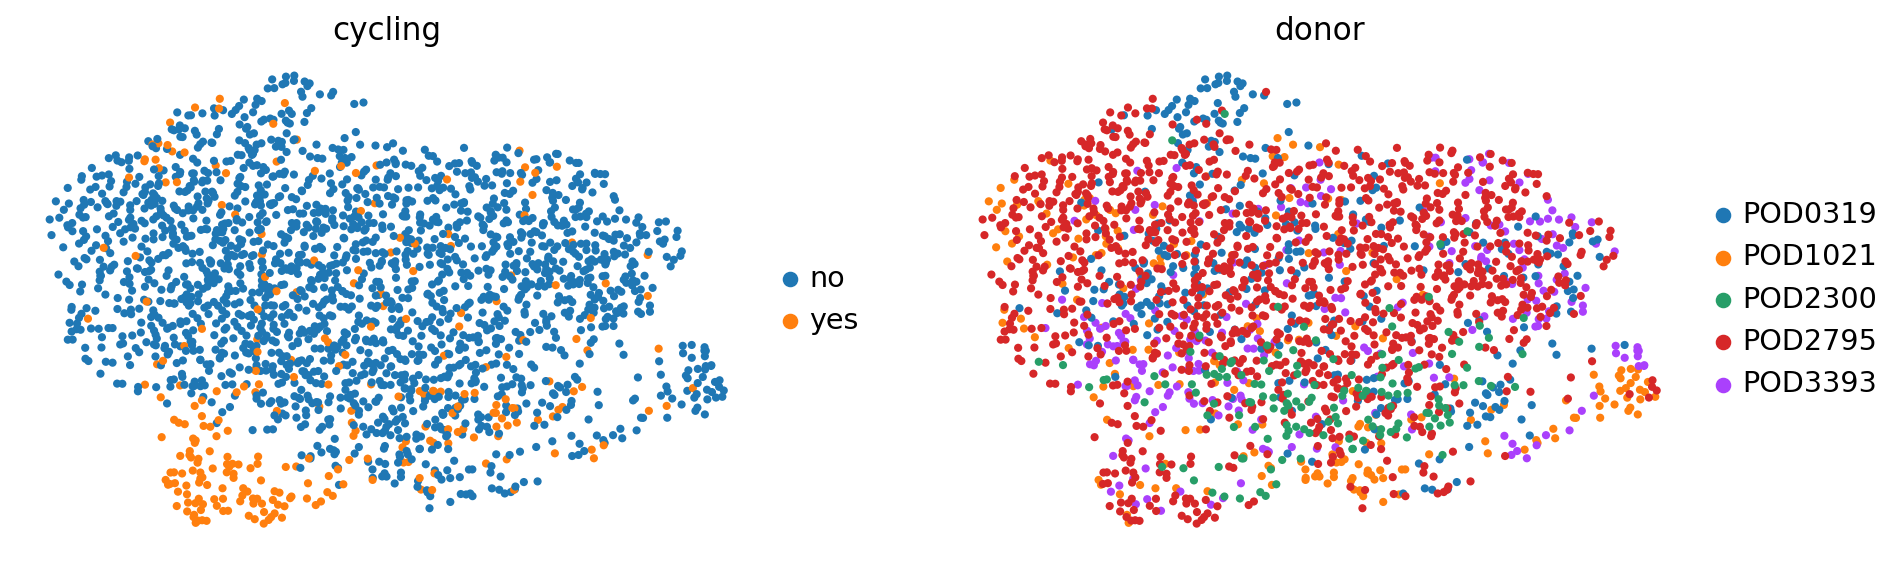

In [25]:
sc.pl.umap(
    adata,
    color=["cycling", "donor"],
    frameon=False,
)

In [81]:
de_df = model.differential_expression(
    groupby="cycling",
)
de_df.head()

Output()

proba_de  proba_not_de  bayes_factor    scale1    scale2  lfc_mean  \
ASPM       0.9688        0.0312      3.435640  0.000376  0.005533 -3.318231   
FAM111B    0.9628        0.0372      3.253537  0.000097  0.001002 -2.934376   
NCAPG      0.9620        0.0380      3.231428  0.000116  0.001251 -2.968791   
BRCA2      0.9546        0.0454      3.045780  0.000528  0.002682 -2.292600   
MYBL2      0.9540        0.0460      3.032022  0.000153  0.000837 -2.443626   

         lfc_median   lfc_std    lfc_min   lfc_max  raw_mean1  raw_mean2  \
ASPM      -3.335159  3.498809 -13.917261  8.964082   0.067623   5.125923   
FAM111B   -2.974285  3.145347 -11.934929  9.815451   0.006148   1.333334   
NCAPG     -3.082656  3.169359 -13.692326  8.712230   0.009734   1.255556   
BRCA2     -2.393096  2.222317  -9.378464  6.072330   0.108606   2.399999   
MYBL2     -2.546804  2.941575 -11.067658  8.635416   0.016393   0.500000   

         non_zeros_proportion1  non_zeros_proportion2  raw_normalized_mean1  \
ASPM                  0.052254               0.437037              0.883375   
FAM111B               0.006148               0.307407              0.068762   
NCAPG                 0.008709               0.314815              0.073986   
BRCA2                 0.077357               0.462963              1.230971   
MYBL2                 0.016393               0.225926              0.156542   

         raw_normalized_mean2  comparison  
ASPM                57.323124  no vs Rest  
FAM111B             10.157923  no vs Rest  
NCAPG               11.348577  no vs Rest  
BRCA2               22.749105  no vs Rest  
MYBL2                6.342213  no vs Rest

In [89]:
markers = {}
cats = adata.obs.cycling.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_mean", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0.1]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2.5]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:15]

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


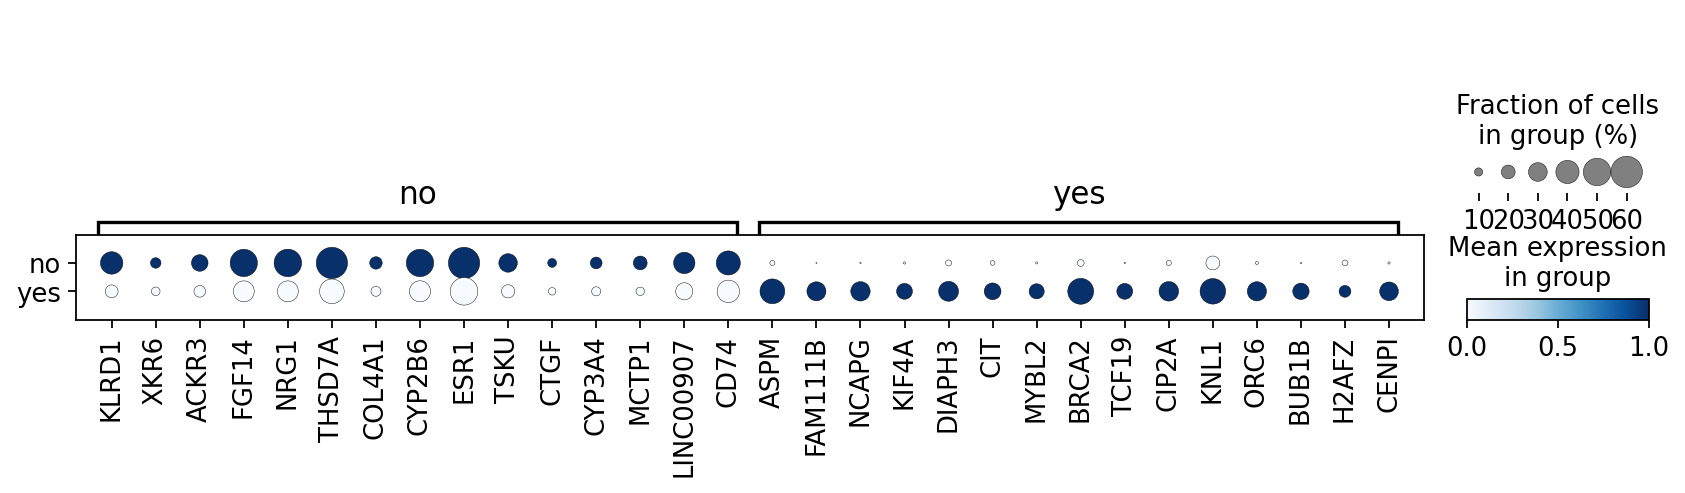

In [90]:
sc.pl.dotplot(
    adata,
    markers,
    groupby='cycling',
    dendrogram=False,
    color_map="Blues",
    swap_axes=False,
    use_raw=True,
    standard_scale="var",
)

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


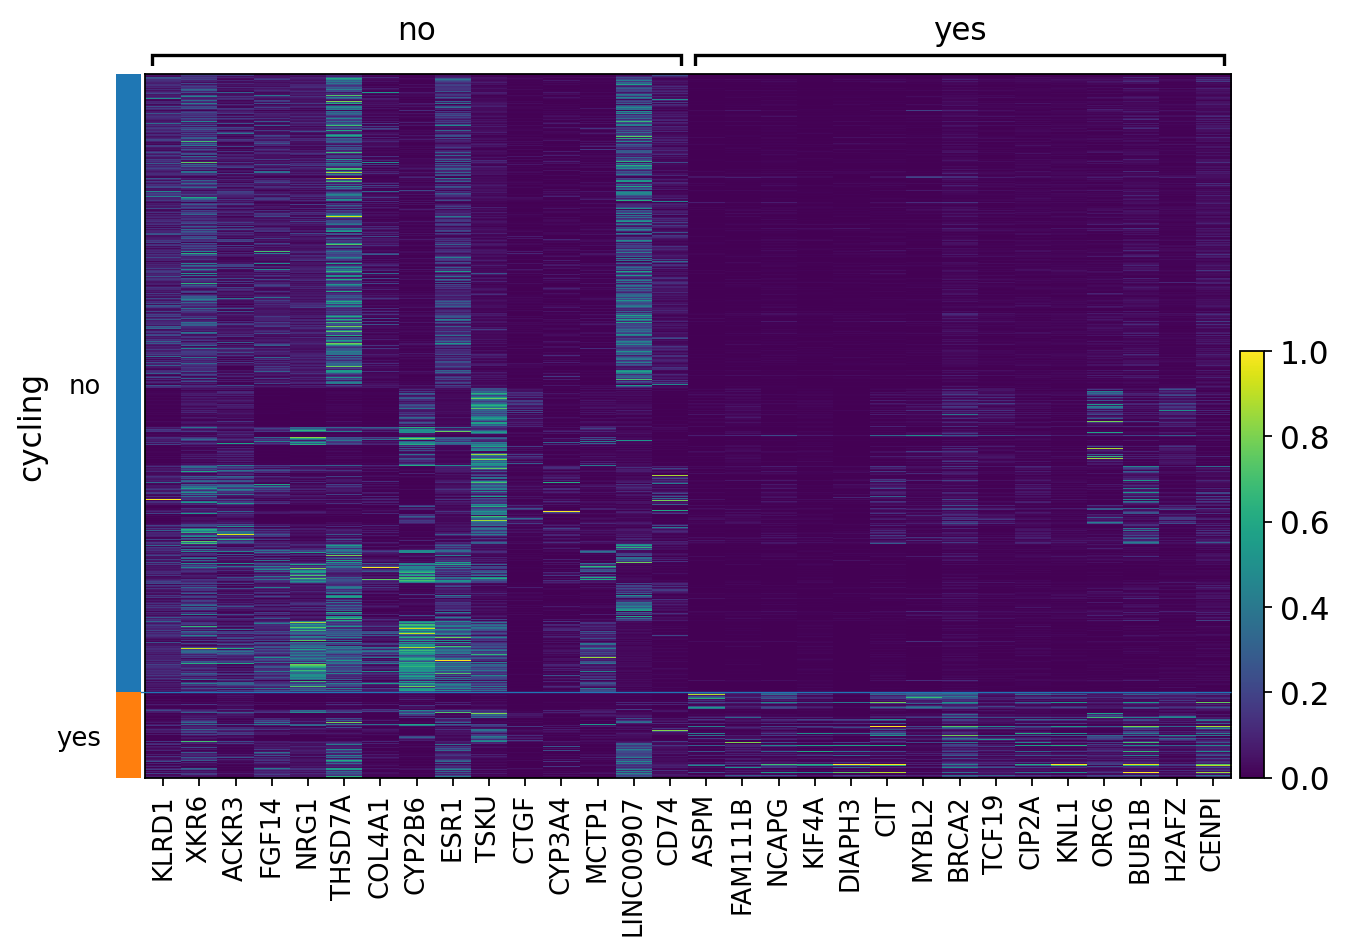

In [91]:
sc.pl.heatmap(
    adata,
    markers,
    groupby='cycling',
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=False,
)


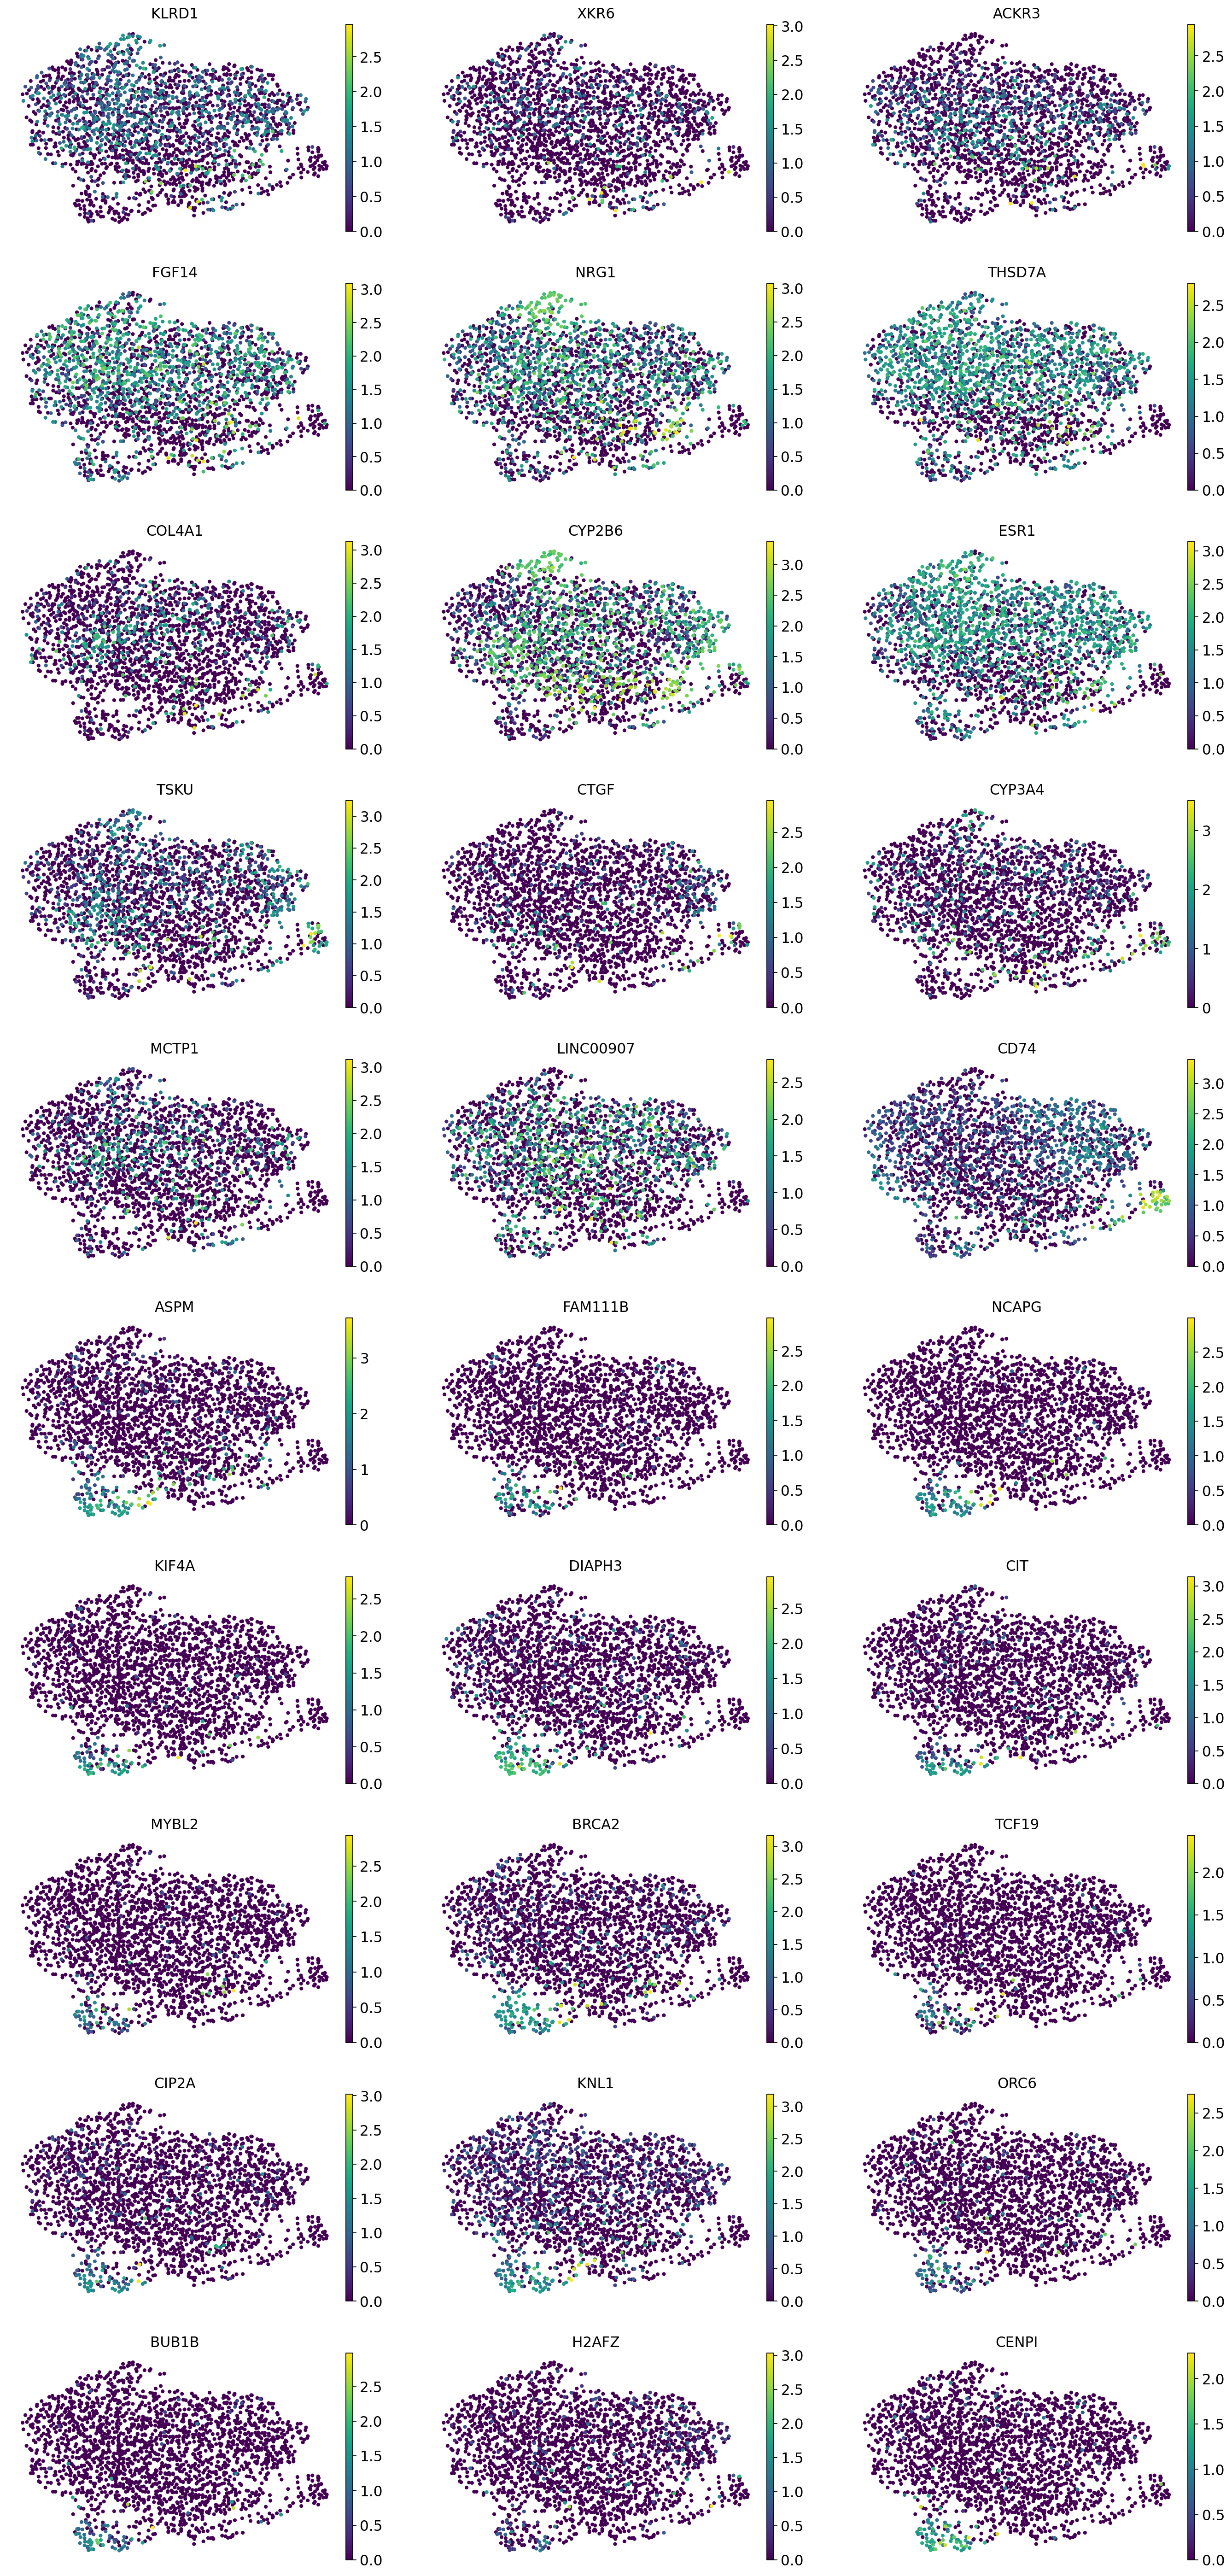

In [92]:
sc.pl.umap(
    adata,
    color=np.array(list(markers.values())).flatten(),
    frameon=False,
    ncols=3
)

In [93]:
model.save("data/scVImodel/")